# Métodos de Cálculo de Distância

## Preparação do ambiente
Vamos importar bibliotecas e definir funções utilitárias para cálculo de distâncias e visualização.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(precision=4, suppress=True)
rng = np.random.default_rng(42)

# ---------- Distâncias básicas ----------

def euclidean(a, b):
    """Distância Euclidiana (L2): ||a - b||_2."""
    a = np.asarray(a, dtype=float)
    b = np.asarray(b, dtype=float)
    return float(np.linalg.norm(a - b, ord=2))

def manhattan(a, b):
    """Distância Manhattan (L1): ||a - b||_1."""
    a = np.asarray(a, dtype=float)
    b = np.asarray(b, dtype=float)
    return float(np.linalg.norm(a - b, ord=1))

def minkowski(a, b, p=3):
    """Minkowski de ordem p (p>=1): (sum |a_i - b_i|^p)^(1/p)."""
    if p < 1:
        raise ValueError("p deve ser >= 1 para ser uma métrica.")
    a = np.asarray(a, dtype=float)
    b = np.asarray(b, dtype=float)
    return float(np.linalg.norm(a - b, ord=p))

def chebyshev(a, b):
    """Chebyshev (L∞): max_i |a_i - b_i|."""
    a = np.asarray(a, dtype=float)
    b = np.asarray(b, dtype=float)
    return float(np.linalg.norm(a - b, ord=np.inf))

# ---------- Cosseno (similaridade e 'distância') ----------

def cosine_similarity(a, b, eps=1e-12):
    """Similaridade do cosseno: (a·b)/(||a|| ||b||)."""
    a = np.asarray(a, dtype=float)
    b = np.asarray(b, dtype=float)
    na = np.linalg.norm(a)
    nb = np.linalg.norm(b)
    if na < eps or nb < eps:
        return 0.0  # vetor nulo → similaridade 0 por convenção
    return float(np.dot(a, b) / (na * nb))

def cosine_distance(a, b, eps=1e-12):
    """'Distância' de cosseno: 1 - similaridade. (Não é métrica no R com negativos)."""
    return 1.0 - cosine_similarity(a, b, eps=eps)

# ---------- Geodésica (Haversine) ----------

def haversine_distance(lat1, lon1, lat2, lon2, radius=6371_000.0):
    """Distância de grande-círculo (Haversine) em METROS.
    Entradas em graus (WGS84 aproximado).
    """
    # radianos
    φ1, λ1, φ2, λ2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dφ = φ2 - φ1
    dλ = λ2 - λ1
    a = np.sin(dφ/2)**2 + np.cos(φ1)*np.cos(φ2)*np.sin(dλ/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return float(radius * c)

# ---------- Mahalanobis ----------

def mahalanobis(a, b, VI=None, X_for_cov=None, reg=1e-8):
    """Distância de Mahalanobis: sqrt((a-b)^T Σ^{-1} (a-b)).
    - Passe VI = Σ^{-1} se já tiver; senão, será estimado de X_for_cov.
    - Usa regularização 'reg' na diagonal ao estimar Σ para evitar singularidade.
    """
    a = np.asarray(a, dtype=float)
    b = np.asarray(b, dtype=float)
    d = a - b
    if VI is None:
        if X_for_cov is None:
            raise ValueError("Forneça VI (Σ^{-1}) ou X_for_cov para estimar a covariância.")
        X = np.asarray(X_for_cov, dtype=float)
        Σ = np.cov(X, rowvar=False)
        Σ = Σ + reg * np.eye(Σ.shape[0])
        VI = np.linalg.inv(Σ)
    return float(np.sqrt(d @ VI @ d))

# ---------- Utilidades ----------

def zscore(X, eps=1e-12):
    """Padronização (z-score) coluna a coluna."""
    X = np.asarray(X, dtype=float)
    mu = X.mean(axis=0)
    sd = X.std(axis=0)
    sd = np.where(sd < eps, 1.0, sd)
    return (X - mu)/sd, mu, sd

def pairwise_distances(X, metric='euclidean', p=3, VI=None, X_for_cov=None):
    """Matriz de distâncias NxN para linhas de X.
    - metric: 'euclidean'|'manhattan'|'minkowski'|'chebyshev'|'cosine'|'mahalanobis'
    - para 'minkowski', use p
    - para 'mahalanobis', passe VI ou X_for_cov
    """
    X = np.asarray(X, dtype=float)
    n = X.shape[0]
    D = np.zeros((n, n), dtype=float)
    for i in range(n):
        for j in range(i+1, n):
            if metric == 'euclidean':
                d = euclidean(X[i], X[j])
            elif metric == 'manhattan':
                d = manhattan(X[i], X[j])
            elif metric == 'minkowski':
                d = minkowski(X[i], X[j], p=p)
            elif metric == 'chebyshev':
                d = chebyshev(X[i], X[j])
            elif metric == 'cosine':
                d = cosine_distance(X[i], X[j])
            elif metric == 'mahalanobis':
                d = mahalanobis(X[i], X[j], VI=VI, X_for_cov=X_for_cov)
            else:
                raise ValueError("métrica desconhecida")
            D[i, j] = D[j, i] = d
    return D


## Por que métricas de distância importam?
Medidas de distância/similaridade são blocos fundamentais para:
- **Busca, ranking, deduplicação** (qual item está mais próximo de outro?).  
- **Aprendizado baseado em vizinhança** (k-NN), **clustering** (k-means, k-medoids), **DBSCAN**, etc.  
- **Detecção de anomalias** (quão longe algo está do "padrão").  
- **NLP e recomendação** (similaridade do cosseno em vetores esparsos/embeddings).  
- **Geolocalização** (distância sobre a superfície da Terra).

A escolha da métrica muda a geometria do problema, afetando resultados e desempenho.


## Dados de exemplo
Vamos criar dados 2D para ilustrações e um conjunto de vetores esparsos para o cosseno.


In [2]:
# Dados 2D (duas nuvens com covariância diferente)
mean1 = np.array([0.0, 0.0])
mean2 = np.array([4.0, 2.0])
C1 = np.array([[1.0, 0.8],
               [0.8, 1.5]])
C2 = np.array([[1.2, -0.6],
               [-0.6, 1.0]])

X1 = rng.multivariate_normal(mean1, C1, size=150)
X2 = rng.multivariate_normal(mean2, C2, size=150)
X = np.vstack([X1, X2])

# Vetores esparsos (bag-of-words toy)
V = np.array([
    [1, 2, 0, 0, 0, 0],
    [0, 1, 0, 3, 0, 0],
    [0, 0, 0, 0, 2, 5],
    [1, 0, 0, 0, 0, 1],
], dtype=float)

print("X shape:", X.shape, "| V shape:", V.shape)


X shape: (300, 2) | V shape: (4, 6)


## Distância **Euclidiana** (L2)
**Definição:** $ d_2(a,b) = \lVert a-b \rVert_2 = \sqrt{\sum_i (a_i-b_i)^2} $.

**Quando usar**  
- Espaços **contínuos** com escala semelhante entre features.  
- Após **padronização** (z-score), quando não há fortes correlações entre as variáveis.  
- Com **k-means** clássico (minimiza soma de quadrados → L2).

**Cuidados**  
- Sensível a **escala** e a **outliers** (eleva diferenças ao quadrado).  
- Não captura **correlações** entre features (para isso, prefira **Mahalanobis**).


Euclidiana(a,b) = 1.4142135623730951

Matriz Euclidiana (8x8):
 [[0.    1.425 3.264 0.53  0.48  1.432 1.433 0.262]
 [1.425 0.    4.161 1.208 1.598 0.214 0.996 1.225]
 [3.264 4.161 0.    3.07  2.81  4.302 3.306 3.506]
 [0.53  1.208 3.07  0.    0.403 1.293 0.931 0.602]
 [0.48  1.598 2.81  0.403 0.    1.665 1.276 0.7  ]
 [1.432 0.214 4.302 1.293 1.665 0.    1.197 1.207]
 [1.433 0.996 3.306 0.931 1.276 1.197 0.    1.401]
 [0.262 1.225 3.506 0.602 0.7   1.207 1.401 0.   ]]


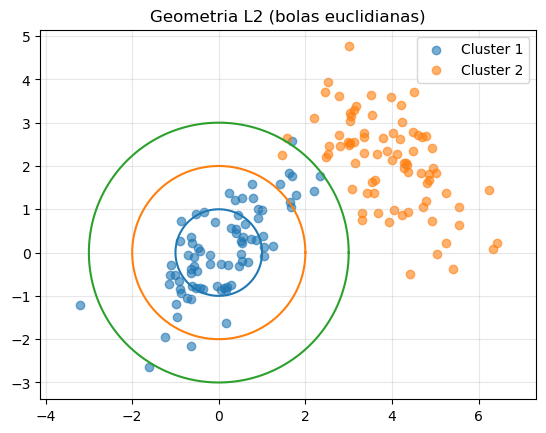

In [3]:
a = np.array([1.0, 2.0, 3.0])
b = np.array([2.0, 1.0, 3.0])
print("Euclidiana(a,b) =", euclidean(a,b))

# Matriz de distâncias euclidianas no conjunto X (subamostra)
Xs = X[:8]
D_euc = pairwise_distances(Xs, metric='euclidean')
print("\nMatriz Euclidiana (8x8):\n", np.round(D_euc, 3))

# Visualização: círculos (bolas L2) e dados
plt.figure()
theta = np.linspace(0, 2*np.pi, 200)
for r in [1, 2, 3]:
    plt.plot(r*np.cos(theta), r*np.sin(theta))
plt.scatter(X1[:80,0], X1[:80,1], alpha=0.6, label="Cluster 1")
plt.scatter(X2[:80,0], X2[:80,1], alpha=0.6, label="Cluster 2")
plt.axis('equal')
plt.title("Geometria L2 (bolas euclidianas)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


## Distância **Manhattan** (L1)
**Definição:** $ d_1(a,b) = \lVert a-b \rVert_1 = \sum_i |a_i-b_i| $.

**Quando usar**  
- Mais **robusta a outliers** do que L2.  
- Dados com **eixos preferenciais** (grades, cidades em quadrícula).  
- Modelos que promovem **esparsidade** (L1 aparece em LASSO como penalidade).

**Cuidados**  
- Também sensível à **escala**; normalize/padronize quando necessário.


Manhattan(a,b) = 2.0

Matriz Manhattan (8x8):
 [[0.    1.64  4.593 0.704 0.624 1.454 2.018 0.354]
 [1.64  0.    5.765 1.43  1.796 0.238 1.357 1.528]
 [4.593 5.765 0.    4.335 3.969 6.003 4.408 4.947]
 [0.704 1.43  4.335 0.    0.437 1.668 1.314 0.612]
 [0.624 1.796 3.969 0.437 0.    2.034 1.751 0.978]
 [1.454 0.238 6.003 1.668 2.034 0.    1.595 1.342]
 [2.018 1.357 4.408 1.314 1.751 1.595 0.    1.906]
 [0.354 1.528 4.947 0.612 0.978 1.342 1.906 0.   ]]


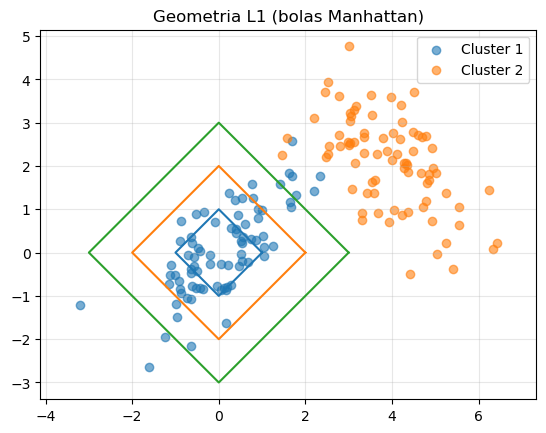

In [4]:
print("Manhattan(a,b) =", manhattan(a,b))

D_l1 = pairwise_distances(Xs, metric='manhattan')
print("\nMatriz Manhattan (8x8):\n", np.round(D_l1, 3))

# Visualização: bolas L1 (losangos)
plt.figure()
r = np.linspace(0, 3, 7)
for rr in [1, 2, 3]:
    t = np.linspace(0, 2*np.pi, 200)
    x = rr*np.cos(t)
    y = rr*np.sin(t)
    # aproxima a bola L1 com a curva |x|+|y|=r
    # param via ângulo → projetando p/ formato 'diamond'
    # Para fins visuais simples, desenhamos o polígono ideal:
    poly = np.array([[ rr, 0],[0, rr],[-rr, 0],[0, -rr],[ rr, 0]])
    plt.plot(poly[:,0], poly[:,1])
plt.scatter(X1[:80,0], X1[:80,1], alpha=0.6, label="Cluster 1")
plt.scatter(X2[:80,0], X2[:80,1], alpha=0.6, label="Cluster 2")
plt.axis('equal')
plt.title("Geometria L1 (bolas Manhattan)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


## **Minkowski** (ordem $p$)
**Definição:**  
$ d_p(a,b) = \left(\sum_i |a_i-b_i|^p\right)^{1/p} $, com $p \ge 1$.  

- $p=1$ → Manhattan  
- $p=2$ → Euclidiana  
- $p \to \infty$ → Chebyshev  

**Quando usar**  
- Para **interpolar** entre L1 e L2 (e além), ajustando sensibilidade a outliers e geometria.  
- Útil em validação para **sintonizar $p$** conforme a tarefa.  


Minkowski p=3 (a,b) = 1.2599210498948732


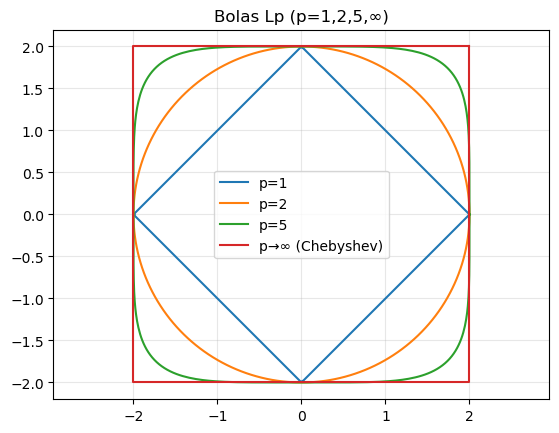

In [5]:
print("Minkowski p=3 (a,b) =", minkowski(a,b,p=3))

# Visual: 'bolas' Lp para p=1, 2, 5 e ∞
def lp_ball(p, r=1.0, n=400):
    t = np.linspace(0, 2*np.pi, n)
    x = np.cos(t)
    y = np.sin(t)
    # normaliza tal que |x|^p + |y|^p = 1 → bola unitária
    denom = (np.abs(x)**p + np.abs(y)**p)**(1/p)
    return r*x/denom, r*y/denom

plt.figure()
for p in [1, 2, 5]:
    x,y = lp_ball(p, r=2.0)
    plt.plot(x,y, label=f"p={p}")
# Chebyshev (p→∞): quadrado de raio r
r=2.0
square = np.array([[ r, r],[ r,-r],[-r,-r],[-r, r],[ r, r]])
plt.plot(square[:,0], square[:,1], label="p→∞ (Chebyshev)")
plt.axis('equal')
plt.title("Bolas Lp (p=1,2,5,∞)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


## **Chebyshev** (L∞)
**Definição:** $ d_{\\infty}(a,b) = \\max_i |a_i-b_i| $.

**Quando usar**  
- Em contextos onde a **maior discrepância** entre componentes limita o sistema (tolerâncias).  
- Em **tabuleiros**/movimento tipo \"rei\" no xadrez; **morfologia matemática** (métrica do supremo).

**Cuidados**  
- Muito sensível ao **pior caso** em qualquer dimensão.


In [6]:
print("Chebyshev(a,b) =", chebyshev(a,b))

D_ch = pairwise_distances(Xs, metric='chebyshev')
print("\nMatriz Chebyshev (8x8):\n", np.round(D_ch, 3))


Chebyshev(a,b) = 1.0

Matriz Chebyshev (8x8):
 [[0.    1.406 2.527 0.481 0.445 1.432 1.102 0.233]
 [1.406 0.    3.472 1.183 1.584 0.212 0.868 1.173]
 [2.527 3.472 0.    2.289 2.081 3.498 2.983 2.647]
 [0.481 1.183 2.289 0.    0.401 1.209 0.693 0.602]
 [0.445 1.584 2.081 0.401 0.    1.61  1.095 0.566]
 [1.432 0.212 3.498 1.209 1.61  0.    1.08  1.199]
 [1.102 0.868 2.983 0.693 1.095 1.08  0.    1.223]
 [0.233 1.173 2.647 0.602 0.566 1.199 1.223 0.   ]]


## **Similaridade do Cosseno** (e 'distância' de cosseno)
**Definição (similaridade):**  
$ s(a,b) = \dfrac{a\cdot b}{\lVert a\rVert \lVert b\rVert} \in [-1,1] $.  

**'Distância' de cosseno:**  
$ d(a,b) = 1 - s(a,b) $.

**Para que serve**  
- Compara **direções** (ângulos) ignorando magnitude. Ótimo para vetores **esparsos** e **TF–IDF**, embeddings, recomendação.  
- Estável quando escalas/contagens variam muito (mesmo padrão de presença é mais relevante do que volume).  

**Cuidados**  
- Não é métrica verdadeira em $\mathbb{R}^n$ quando valores podem ser negativos (violação da desigualdade triangular em alguns casos).  
- Requer lidar com **vetor nulo** (definir similaridade 0 por convenção).  

In [7]:
u = np.array([10,0,0,1,0,0], dtype=float)
v = np.array([1,0,0,0,0,1], dtype=float)
w = 10*u  # mesmo sentido que u, magnitude maior

print("cos(u,v) =", cosine_similarity(u,v))
print("cos(u,w) =", cosine_similarity(u,w), "(invariância à escala)")
print("dist_cosseno(u,w) =", cosine_distance(u,w))

D_cos = pairwise_distances(V, metric='cosine')
print("\nMatriz 'distância' de cosseno (4x4):\n", np.round(D_cos, 3))


cos(u,v) = 0.7035975447302919
cos(u,w) = 1.0000000000000002 (invariância à escala)
dist_cosseno(u,w) = -2.220446049250313e-16

Matriz 'distância' de cosseno (4x4):
 [[0.    0.717 1.    0.684]
 [0.717 0.    1.    1.   ]
 [1.    1.    0.    0.343]
 [0.684 1.    0.343 0.   ]]


## **Geodésica** (superfície da Terra)
**Problema:** Coordenadas geográficas (lat, lon) são ângulos em uma esfera aproximada — **distância euclidiana em graus não faz sentido físico**.  
**Solução:** Use **grande-círculo** (Haversine/Vincenty).

**Uso típico**  
- Logística/rotas, *geo-fencing*, \"qual loja está mais próxima?\".  
- Pré-processamento para features de proximidade em modelos.

**Boas práticas**  
- Mantenha lat/lon em **graus**, converta internamente para **radianos**.  
- Distâncias normalmente em **metros** (ou **km**).  
- Para precisão sub-métrica/áreas grandes, considere elipsóides (Vincenty). Aqui usamos **Haversine**.


In [8]:
# Distâncias aproximadas entre algumas cidades (lat,lon ~ WGS84)
cities = {
    "São Paulo": (-23.5505, -46.6333),
    "Rio de Janeiro": (-22.9068, -43.1729),
    "Belo Horizonte": (-19.9167, -43.9345),
    "Brasília": (-15.7939, -47.8828),
    "Lisboa": (38.7223, -9.1393),
    "Madri": (40.4168, -3.7038),
}

def km(d_m): return d_m/1000.0

pairs = [
    ("São Paulo","Rio de Janeiro"),
    ("Lisboa","Madri"),
    ("Brasília","Belo Horizonte"),
]

for a,b in pairs:
    d = haversine_distance(*cities[a], *cities[b])
    print(f"{a:14s} ↔ {b:14s} ≈ {km(d):8.2f} km")


São Paulo      ↔ Rio de Janeiro ≈   360.75 km
Lisboa         ↔ Madri          ≈   502.45 km
Brasília       ↔ Belo Horizonte ≈   620.23 km


## **Mahalanobis**
**Definição:**  
$ d_M(a,b) = \sqrt{(a-b)^T\,\Sigma^{-1}\,(a-b)} $, onde $\Sigma$ é a **covariância** do conjunto de dados.

**Para que serve**  
- **Invariante a re-escalonamentos lineares** e sensível a **correlações** entre features.  
- Detecta **anomalias** (distância ao centro em unidades de desvio-padrão generalizado).  
- Útil em **classificação** quando cada classe tem covariância própria (LDA/QDA).

**Cuidados**  
- Requer estimar $\Sigma$ e inverter $\Sigma$: com poucas amostras ou features colineares, use **regularização**.  
- **Padronizar** e remover outliers extremos melhora a estabilidade.

Mahalanobis(a,b) com Σ do X = 0.9244704507820592


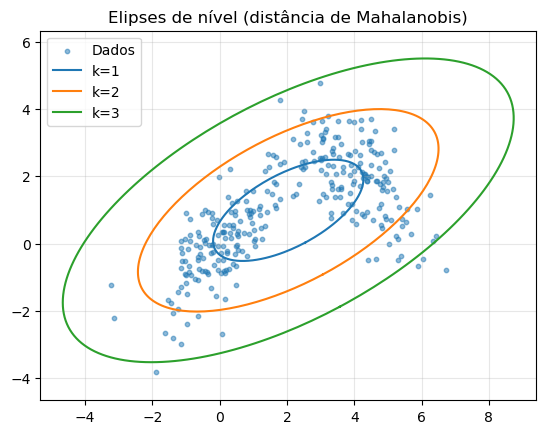

In [9]:
# Estimando Σ a partir do conjunto X e visualizando contornos de distância
Σ = np.cov(X, rowvar=False)
Σ += 1e-6*np.eye(Σ.shape[0])  # regularização leve
VI = np.linalg.inv(Σ)

# Centro (média global)
mu = X.mean(axis=0)

# Distância ao centro (score de outlier)
d_center = np.array([mahalanobis(x, mu, VI=VI) for x in X])

print("Mahalanobis(a,b) com Σ do X =", mahalanobis(X[0], X[1], VI=VI))

# Visualização de elipses de nível de Mahalanobis
vals, vecs = np.linalg.eigh(np.linalg.inv(VI))  # autovalores de Σ
order = np.argsort(vals)[::-1]
vals, vecs = vals[order], vecs[:,order]

def ellipse(mu, cov, k=1.0, n=200):
    # nível k: (x-mu)^T Σ^{-1} (x-mu) = k^2 → elipse com raios k*sqrt(λ_i) nos eixos de Σ
    w, V = np.linalg.eigh(cov)
    t = np.linspace(0, 2*np.pi, n)
    circle = np.stack([np.cos(t), np.sin(t)]).T
    E = (V @ (np.sqrt(np.maximum(w, 1e-15))*circle).T).T * k + mu
    return E

plt.figure()
plt.scatter(X[:,0], X[:,1], s=10, alpha=0.5, label="Dados")
for k in [1,2,3]:
    E = ellipse(mu, Σ, k=k)
    plt.plot(E[:,0], E[:,1], label=f"k={k}")
plt.axis('equal')
plt.title("Elipses de nível (distância de Mahalanobis)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


## Escala e normalização: efeito prático
Métricas Lp (L1/L2/...) são sensíveis à **escala**.  
Compare abaixo matrizes de distância euclidiana antes e depois de **padronizar** (z-score).


In [10]:
# duas features com escalas diferentes
X_scale = np.copy(Xs)
X_scale[:,0] *= 50.0  # estica a 1ª dimensão

D_raw = pairwise_distances(X_scale, metric='euclidean')
X_std, mu, sd = zscore(X_scale)
D_std = pairwise_distances(X_std, metric='euclidean')

print("Euclidiana com escalas diferentes (maiores diferenças no 1º eixo):\n", np.round(D_raw,2))
print("\nEuclidiana após z-score (escala equilibrada):\n", np.round(D_std,2))


Euclidiana com escalas diferentes (maiores diferenças no 1º eixo):
 [[  0.    70.28 103.35  11.15   8.94  71.59  45.83  11.64]
 [ 70.28   0.   173.61  59.14  79.21   1.33  24.48  58.64]
 [103.35 173.61   0.   114.48  94.41 174.93 149.14 114.99]
 [ 11.15  59.14 114.48   0.    20.07  60.45  34.68   0.78]
 [  8.94  79.21  94.41  20.07   0.    80.52  54.74  20.57]
 [ 71.59   1.33 174.93  60.45  80.52   0.    25.8   59.95]
 [ 45.83  24.48 149.14  34.68  54.74  25.8    0.    34.2 ]
 [ 11.64  58.64 114.99   0.78  20.57  59.95  34.2    0.  ]]

Euclidiana após z-score (escala equilibrada):
 [[0.   1.37 3.67 0.63 0.57 1.37 1.61 0.27]
 [1.37 0.   4.34 1.17 1.53 0.26 1.16 1.2 ]
 [3.67 4.34 0.   3.32 3.12 4.53 3.34 3.91]
 [0.63 1.17 3.32 0.   0.39 1.28 1.01 0.74]
 [0.57 1.53 3.12 0.39 0.   1.62 1.32 0.8 ]
 [1.37 0.26 4.53 1.28 1.62 0.   1.41 1.16]
 [1.61 1.16 3.34 1.01 1.32 1.41 0.   1.63]
 [0.27 1.2  3.91 0.74 0.8  1.16 1.63 0.  ]]


## Qual métrica muda o vizinho mais próximo?
Para um ponto de consulta, a métrica escolhida pode mudar **quem é o vizinho mais próximo**.  
Abaixo comparamos Euclidiana, Manhattan, Chebyshev e Cosseno em uma pequena amostra.


Métrica: euclidean  | vizinho idx= 2 | distância=0.8490
Métrica: manhattan  | vizinho idx= 2 | distância=1.1198
Métrica: chebyshev  | vizinho idx= 2 | distância=0.7765
Métrica: cosine     | vizinho idx=12 | distância=0.0076


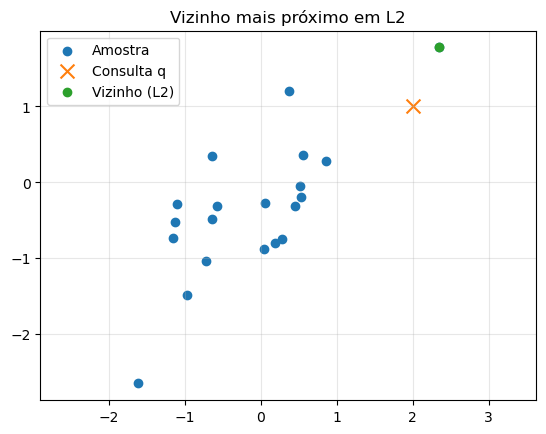

In [11]:
q = np.array([2.0, 1.0])  # ponto de consulta
Xs2 = X[:20]

def argmin_metric(Xs, q, metric):
    best_i, best_d = None, float('inf')
    for i, x in enumerate(Xs):
        if metric == 'euclidean':
            d = euclidean(x, q)
        elif metric == 'manhattan':
            d = manhattan(x, q)
        elif metric == 'chebyshev':
            d = chebyshev(x, q)
        elif metric == 'cosine':
            d = cosine_distance(x, q)
        else:
            raise ValueError("métrica não suportada aqui")
        if d < best_d:
            best_d, best_i = d, i
    return best_i, best_d

for metric in ['euclidean', 'manhattan', 'chebyshev', 'cosine']:
    i, d = argmin_metric(Xs2, q, metric)
    print(f"Métrica: {metric:10s} | vizinho idx={i:2d} | distância={d:.4f}")

# Visualização para Euclidiana
plt.figure()
plt.scatter(Xs2[:,0], Xs2[:,1], label="Amostra")
plt.scatter([q[0]],[q[1]], marker='x', s=100, label="Consulta q")
i, d = argmin_metric(Xs2, q, 'euclidean')
plt.scatter([Xs2[i,0]], [Xs2[i,1]], label="Vizinho (L2)")
plt.axis('equal')
plt.title("Vizinho mais próximo em L2")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


## Comparativo rápido (resumo prático)

| Métrica | O que mede | Invariâncias / Sensibilidades | Usos comuns |
|---|---|---|---|
| **Euclidiana (L2)** | Comprimento "reta" | Rotação-invariante; sensível a escala/outliers | k-means, PCA, espaço contínuo padronizado |
| **Manhattan (L1)** | Soma de desvios | Mais robusta a outliers; sensível à escala | k-medoids, dados com eixos fortes |
| **Minkowski (p)** | Interpola L1–L2–L∞ | Ajusta sensibilidade via p | Validação/ajuste de métrica |
| **Chebyshev (L∞)** | Maior discrepância | Foca no pior eixo | Tolerâncias, xadrez, morfologia |
| **Cosseno** | Ângulo entre vetores | Invariante à magnitude | NLP (TF–IDF), embeddings, recomendação |
| **Geodésica** | Distância sobre a Terra | Escala real (m/km) | Logística, geofence, nearest store |
| **Mahalanobis** | Distância padronizada por Σ | Leva escala e correlação em conta | Anomalias, LDA/QDA, clusters elípticos |
